# Simulación de un sistema de dos niveles: Resonancia Magnética y MASER

En este proyecto revisaremos el famoso problema del sistema de dos niveles en un potencial sinusoidal. Basaremos la discusión en las ideas del capítulo 5 del famoso libro de Sakurai y Napolitano sobre mecánica cuántica; así como las notas de clase de Barton Zweibach, profesor del MIT. 

Siguiendo a este último, estudiaremos la precesión de una partícula con espín $1/2$ desde los puntos de vista matemático y de la computación cuántica. Con la intuición desarrollada, introduciremos un campo magnético rotatorio y estudiaremos la **resonancia magnética de espín** por medio de una aproximación directa. Finalmente, consideraremos la **representación de eje rotante** de Rabi y Schwinger para simular la resonancia de espín.

**NOTA:** El lector puede seguir este proyecto de forma interactiva desde nuestro servidor de MyBinder, haciendo click en el botón. Recomendamos hacer una lectura del post, de modo que las intuiciones físicas sean más claras a la hora de realizar la práctica.

<p align="center">
  <a href="https://mybinder.org/v2/gh/QC-FEM/QC-Articles/HEAD">
    <img src="https://mybinder.org/badge_logo.svg">
  </a>
</p>

## Precesión de espín

Pra mayor claridad, consideraremos una partícula de espín $1/2$ en presencia de un campo magnético externo constante $\vec{B_0}$. Para el lector con poca experiencia en mecánica cuántica, el espín es una propiedad intrínseca de una partícula que es similar a un momento angular. El espín hace que una partícula interactúe con un campo magnético, incluso cuando no se encuentra en movimiento. El espín $1/2$ puede caracterizarse por dos estados, que denominaremos $| +1/2 \rangle$ y $| -1/2 \rangle$.

**IMPORTANTE:** En otro momento hablaremos un poco más sobre las propiedades del espín. Por ahora, es suficiente con identificar los estados de espín de una partícula con los estados base de un qubits. Así, realizamos la identificación

$$| +1/2 \rangle \equiv |0\rangle$$
$$| -1/2 \rangle \equiv |1\rangle$$

> Aún más, el vector de Bloch del estado de un qubit es una representación bastante buena de lo que imaginamos como el espín de una partícula. Recomendamos al lector con poca familiaridad en física cuántica que traiga a su mente esta imagen a la hora de desarrollar una intuición en la realización de este proyecto.

<p align="center">
    <img src="TwoStateProblems_files/Blochsphere.png" width="500" height="500">
</p>

Sin pérdida de generalidad, consideraremos un campo magnético que puede representarse por un vector

$$\vec{B}_0 = B_0 \big[\sin{\phi_0}\cos{\theta_0}\hat{\mathbf{x}} + \sin{\phi_0}\sin{\theta_0}\hat{\mathbf{y}} + \cos{\theta_0}\hat{\mathbf{z}}\big] = B_0 \hat{n}$$

> Es conveniente imaginar el campo magnético como un eje apuntando en dirección definida por $\phi_0,\theta_0$, en la esfera de Bloch.

El **operador de espín** de una partícula puede ser identificado con los **operadores de Pauli** de la computación cuántica. Realizamos la equivalencia

$$\hat{S}_i \equiv \hat{\sigma}_i$$
$$\vec{S} \equiv \sigma_x \hat{\mathbf{x}} + \sigma_z \hat{\mathbf{z}} + \sigma_z \hat{\mathbf{z}}$$

De la teoría electromagnética es posible deducir que un campo magnético interactúa con el espín de una partícula produciendo un **Hamiltoniano** (i.e. *operador de enegía de interacción*)

$$\hat{H}_0 = - \vec{B}_0 \cdot \vec{S} = -B_0 \hat{n} \cdot \hat{\sigma}$$

Con esta notación significamos la suma de operadores de Pauli

$$\hat{n} \cdot \hat{\sigma} = n_x \hat{\sigma}_x + n_y \hat{\sigma}_y + n_z \hat{\sigma}_z$$

Con esta imagen, podemos realizar dos afirmaciones. En primer lugar, si el espín es paralelo al campo magnético, la energía de interacción es mínima. En segundo lugar, si el espin y el campo magnético son antiparalelos, la energía de interacción es máxima. Definimos dos estados particulares de espín, que denominaremos **estado base** ($|\hat{n},+\rangle$) y **estado excitado** ($|\hat{n},-\rangle$):

$$|\hat{n},+\rangle = \cos{\frac{\theta_0}{2}}|0\rangle + \mathrm{e}^{\mathrm{i\phi_0}}\sin{\frac{\theta_0}{2}}|1\rangle$$
$$|\hat{n},-\rangle = \sin{\frac{\theta_0}{2}}|0\rangle - \mathrm{e}^{\mathrm{i\phi_0}}\cos{\frac{\theta_0}{2}}|1\rangle$$

Invitamos al lector a demostrar que estos satisfacen

$$\hat{H}_0 |\hat{n},+\rangle = -B_0|\hat{n},+\rangle$$
$$\hat{H}_0 |\hat{n},-\rangle = +B_0|\hat{n},-\rangle$$

### Evolución temporal

Una vez establecida la notación y algunas características del sistema que vamos a considerar, podemos proceder a estudiar la evolución del mismo en el tiempo. Es un postulado de la mecánica cuántica que el operador Hamiltoniano produce la evolución unitaria del estado de un sistema cuántico cualquiera. Esto tiene que ver con la noción de los operadores de energía como generadores de traslaciones temporales de las coordenadas de un sistema. Por el momento, es suficiente interiorizar que el operador que realiza la evolución temporal de nuestra partícula es

$$\hat{U}_0(t) = \exp(-\mathrm{i}\hat{H}_0 t) = \exp[-\mathrm{i}(-B_0t) \hat{n} \cdot \hat{\sigma}]$$

> En computación cuántica reconocemos inmediatamente que el operador de evolución temporal corresponde a una rotación alrededor del eje $\hat{n}$, por un ángulo $-2B_0 t$.

Por tanto, dado un estado inicial de espín $|\psi(0)\rangle$, el estado en un instante posterior puede encontrarse calculando

$$|\psi(t)\rangle = R_{\hat{n}}(-2B_0 t)|\psi(0)\rangle$$

> En este punto es importante anotar que los operadores de rotación tienen definiciones ligeramente distintas en el contexto de la computación cuántica y del estudio de partículas de espín 1/2. En el primero $R_{\hat{n}}(\theta) = \exp(-\mathrm{i}\theta \hat{n} \cdot \hat{\sigma}/2)$.

Siguinedo esta convención, en computación cuántica, diremos que la velocidad angular de la rotación de nuestro estado de espín es

$$\omega_0 = 2 B_0$$

La denominaremos **frecuencia de Larmor**.

#### Simulación con Qiskit

Sin pérdida de generalidad, asumiremos que $\hat{n} = \hat{\mathbf{y}}$. Construiremos un circuito que simule la evolución temporal de nuestra partícula. Para ello, importaremos las funciones necesarias

In [1]:
## Para operaciones matemáticas
import numpy as np
## Para apartar espacio en memoria
from qiskit import QuantumRegister, ClassicalRegister
## Para crear un circuito cuántico
from qiskit import QuantumCircuit
## Para parametrizar operadores
from qiskit.circuit import Parameter
## Para simular el circuito
from qiskit import execute, Aer
## Para visualizar el vector de estado
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector

En una primera instancia, simularemos directamente la evolución del vector de estado, y nos familiarizaremos con la precesión de espín. Posteriormente, realizaremos una simulación de la ejecución de nuestro circuito en un procesador cuántico.

**Evolución del vector de estado**

Para simular el sistema con un circuito cuántico, utilizaremos un qubit. Después de inicializar el estado del qubit, aplicaremos una compuerta ```Rz(-2 * B0 * t)``` y observaremos el cambio en el vector de estado. Seguiremos la secuencia paso a paso.

1. *Creación del circuito*: Ejecutamos los comandos

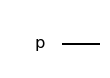

In [2]:
## Declaramos el registro cuántico
particula = QuantumRegister(1,name='p')
## Creamos el circuito
circuito = QuantumCircuit(particula)
## Dibujamos el circuito
circuito.draw(output='mpl')

2. *Inicializamos el estado*: Para cargar un estado inicial, utilizamos ```initialize()``` de Qiskit. El estado puede guardarse como un ```ndarray``` o una lista.

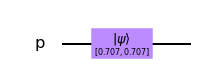

In [3]:
## Definimos el estado inicial
theta = np.pi * 1/2
phi = np.pi * 0
psi0 = [np.cos(theta/2), np.sin(theta/2)*np.exp(1j*phi)]
## Damos la instrucción initialize
circuito.initialize(psi0,particula)
## Dibujamos el circuito
circuito.draw(output='mpl')

3. *Realizamos la simulación temporal*: Para apreciar la precesión, primero observaremos el estado inicial del sistema

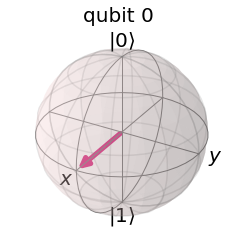

In [4]:
## Definimos el vector de Bloch
bloch_vec = [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]
plot_bloch_multivector(psi0)

Con esta perspectiva, procedemos a realizar la simulación. Tomaremos un tiempo de evolución $t = \pi/4$ y una intensidad de campo magnético $B_0 = 1$. El operador de evolución temporal resulta entonces

$$\hat{U}(t) = \hat{R}_{\hat{y}}(-\pi/2)$$

**IMPORTANTE:** Para simular el vector de estado debemos utilizar ```Aer``` con el fin de establecer como ```backend``` el simulador ```statevector_simulator```. Un ```backend``` es simplemente una plataforma donde llevar a cabo el algoritmo.

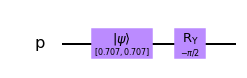

In [5]:
## Añadimos la rotación
circuito.ry(-np.pi/2,particula)
## Dibujamos el circuito
circuito.draw(output='mpl')

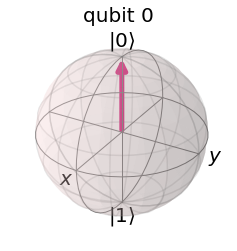

In [6]:
## Definimos el backend
backend = Aer.get_backend('statevector_simulator')
## Ejecutamos el algoritmo
psit = execute(circuito,backend).result().get_statevector()
## Dibujamos el estado de espin en la esfera de Bloch
plot_bloch_multivector(psit)

Como se puede observar, la evolución temporal corresponde a una rotación del espín en la esfera de Bloch, en sentido horario, con respecto al eje $\hat{y}$. Este fenómeno es lo que se denomina **precesión de espín**. Invitamos al lector a variar el tiempo de simulación y el estado inicial para observar este fenómeno más en detalle.

En un procesador cuántico, sin embargo, no tenemos acceso directo al vector de estado. Solamente podemos medir en la base computacional y registrar la estadística de los resultados. Así que ahora procedemos a emular la simulación de nuestra partícula en un procesador cuántico.

**Simulación en un procesador cuántico**

El operador de evolución temporal depende paramétricamente del tiempo. Por tanto, crearemos una rotación que depende implícitamente de ```t``` en Qiskit. Esto requiere la definición de un ```Parameter```. Posteriormente, construiremos una secuencia de circuitos que luego simularemos con el ```backend``` denominado ```qasm_simulator```.

1. *Crear ```Parameter``` y lista de tiempos a simular*: Después de crear el parámetro del cual dependen las rotaciones, definiremos la lista que contendrá los tiempos durante los cuales simularemos el sistema.

In [7]:
## Definición Parameter
t = Parameter('t')
## lista de tiempos
tiempos = np.linspace(0,1,100)

2. *Implementamos el algoritmo*: Dado que simularemos la ejecución de un circuito en un procesador cuántico, necesitamos un *registro clásico* para poder guardar los resultados de la medición. Asumiremos $B_0 = \pi$.

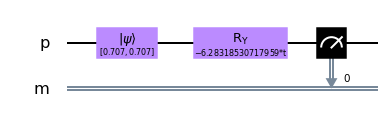

In [8]:
## Creamos registro clásico
medida = ClassicalRegister(1,name='m')
## Creamos el circuito con dependencia paramétrica
Simul = QuantumCircuit(particula,medida)
## Cargamos un estado inicial
Simul.initialize(psi0,particula)
## Aplicamos la rotación paramétrica
Simul.ry(-2*np.pi*t,particula)
## MEDIMOS EL QUBIT
Simul.measure(particula,medida)
## Dibujamos el circuito
Simul.draw(output='mpl')

3. *Simulamos una secuencia de circuitos*: Con esto podemos evaluar la densidad de probabilidad de medir en la base de espín de nuestra partícula en distintos instantes de tiempo. Es decir, simularemos el proceso de llevar a cabo la evolución temporal con un procesador cuántico ideal, y luego realizar varias mediciones en la base computacional para sacar una distribución de probabilidades

**NOTA:** Cada proceso de evolución-medición se repetirá 2048 veces por cada tiempo.

In [9]:
## Definimos el backend
backend = Aer.get_backend('qasm_simulator')
## Simulamos la ejecución del circuito
Emulacion = execute(Simul,backend=backend,shots=2048,parameter_binds=[{t:tiempo} for tiempo in tiempos])
## Capturamos los resultados de medir en la base de espín
PDF = Emulacion.result().get_counts()

Ahora podemos presentar la evolución temporal de la densidad de probabilidad. Para ello, graficaremos la probailidad de medir un valor de bit 0 y la probabilidad de medir un valor de bit 1 como función del tiempo.

**IMPORTANTE:** La simulación de un circuito produce como salida un diccionario de Python que contiene la estadística de medición en la base computacional. En nuestro caso, ya que simulamos varios circuitos, el resultado de la simulación es una lista de diccionarios que contienen la estadística de medición en cada instante de tiempo consirado. Recuperaremos la probabilidad de medir un cierto valor de bit utilizando la función miembro ```get()```.

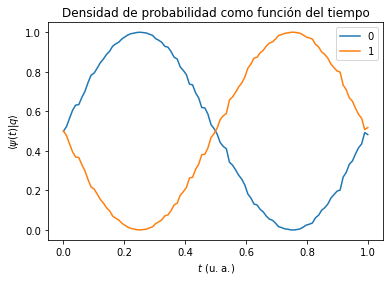

In [10]:
## Utilizamos matplotlib para dibujar
import matplotlib.pyplot as plt
## Capturamos la probabilidad de medir 0
prob0s = np.array([resultado.get('0',0) for resultado in PDF])
## Capturamos la probabilidad de medir 1
prob1s = np.array([resultado.get('1',0) for resultado in PDF])
## Hacemos el dibujo
plt.title(r'Densidad de probabilidad como función del tiempo')
plt.xlabel(r'$t$ (u. a.)')
plt.ylabel(r'$\langle \psi(t) | q \rangle$')
plt.plot(tiempos,prob0s/2048,label='0')
plt.plot(tiempos,prob1s/2048,label='1')
plt.legend()
plt.show()

Estas curvas oscilantes permiten identificar la precesión del espín a lo largo de un eje en la esfera de Bloch. Como puede observarse, la frecuencia de la precesión (i. e. rotación alrededor del eje definido) es proporcional a la intensidad del campo. Invitamos al lector a comparar está gráfica a la luz de la acción que realiza la evolución temporal sobre el espín en la esfera de Bloch.

**SUPER IMPORTANTE:** Invitamos al lector a considerar que pasaría si se evolucionara el estado base o el estado excitado del sistema. ¿Existiría precesión? ¿Podría existir una transición del estado base al estado excitado?

## Resonancia magnética de espín

La interacción que hemos estudiado no es muy interesante, ya que no induce transiciones entre el estado base y el estado excitado de la partícula. Para el lector con poca familiaridad con la física cuántica, una transición entre dos estados es un fenómeno en el cual el estado de un sistema cambia a otro. Decimos que la trnasición corresponde a una excitación, si la transición ocurre de un estado de menor energía, a otro de mayor energía. En contraste, diremos que la transición es un decaimiento, si ocurre de un estado de mayor energía a otro de menor energía.

> Para introducir transiciones entre el estado excitado y el estado base de un sistema de espín en presencia de un campo magnético constante, incluiremos una pequeña componente con polarización circular.

El campo magnético estará representado por el vector

$$\vec{B}(t) = B_0 \hat{\mathbf{z}} + B_1 \cos{\omega t}\hat{\mathbf{x}} - B_1 \sin{\omega t}\hat{\mathbf{y}}$$

Invitamos al lector a convencerse de que este campo magnético presenta precesión en torno del eje $z$, rotando en dirección de las manecillas del reloj. En primera instancia, consideraremos el formalismo matemático que permite identificar la posibilidad de transiciones de estado con este campo magnético. Finalmente, consideraremos el formalismo del marco rotante de Rabi y Schwinger para simular el sistema con un procesador cuántico.

### Formalismo matemático

Esta sección es de mayor provecho para lectores con experiencia en mecánica cuántica. Consideraremos el Hamiltoniano del sistema, plantearemos la ecuación de Schrödinger y presentaremos la evolución temporal de la densidad de probabilidad de medición en la base computacional.

#### El Hamiltoniano del sistema

Como hemos visto anteriormente, el Hamiltoniano de interacción entre el campo magnético y el espín de nuestra partícula está dado por la expresión

$$\hat{H} = - B_0 \hat{\sigma}_z - B_1 \cos{\omega t} \hat{\sigma}_x + B_1 \sin{\omega t} \hat{\sigma}_y$$

Consideremos la representación matricial de este Hamiltoniano en la base computacional

$$\hat{H} = -\begin{bmatrix} B_0 & B_1 \mathrm{e}^{\mathrm{i}\omega t} \\ B_1 \mathrm{e}^{-\mathrm{i}\omega t} & -B_0\end{bmatrix}$$

Plantearemos la ecuación de Schrödinger para el sistema en esta base.

#### Ecuación de Schrödinger

Supondremos que en $t = 0$, sabemos con seguridad que la partícula se encuentra en el estado base del Hamiltoniano independiente del tiempo que vimos en la sección sobre precesión de espín. Además, asumiremos que la componente del campo independiente del tiempo se orienta paralela al eje z de la esfera de Bloch. El estado de espín de la partícula puede representarse por medio de la combinación lineal

$$|\psi(t)\rangle = c_0(t)|0\rangle + c_1(t)|1\rangle$$

De esta forma, la ecuación de Schrödinger para el sistema

$$\mathrm{i}\frac{\mathrm{d}}{\mathrm{d}t}|\psi(t)\rangle = \hat{H} |\psi(t)\rangle$$

Se transforma en un sistema de ecuaciones que puede resumirse por la expresión

$$\mathrm{i}\frac{\mathrm{d}}{\mathrm{d}t}\begin{bmatrix}c_0(t) \\ c_1(t)\end{bmatrix} = -\begin{bmatrix} B_0 & B_1 \mathrm{e}^{\mathrm{i}\omega t} \\ B_1 \mathrm{e}^{-\mathrm{i}\omega t} & -B_0\end{bmatrix}\begin{bmatrix}c_0(t) \\ c_1(t)\end{bmatrix}$$

#### Densidad de probailidad en la base computacional

De acuerdo con los postulados de la mecánica cuántica, la probabilidad de medir un valor de bit $i$ ($i = 0,1$), dado el estado del sistema en un instante de tiempo, está dada por la cantidad

$$p(i|\psi(t)) = |\langle \psi(t)| i\rangle|^2$$

De acuerdo con nuestra convención advertimos que

$$p(0|\psi(t)) = |c_0(t)|^2$$
$$p(1|\psi(t)) = |c_1(t)|^2$$

Para evitar desviar la atención de la esencia del problema, presentamos los resultados de resolver el sistema de ecuaciones y calcular las probabilidades de medición en la base computacional, en el caso particular $c_0(0) = 1$, $c_1(0) = 0$; es decir, considerando una partícula en el estado base:

$$p(0|\psi(t)) = 1 - p(1|\psi(t))$$
$$p(1|\psi(t)) = \frac{B_1^2}{\Omega_0^2} \sin^2{\Omega_0 t}$$

Donde hacemos la definición

$$\Omega_0 = \sqrt{B_1^2 + \bigg(\frac{\omega - 2 B_0}{2}\bigg)^2}$$

Para entender las implicaciones de este resultado, incluimos una herramienta interactiva que permite evaluar la densidad de probailidad para distintos instantes de tiempo. Tomamos los valores

$$B_0 = 10$$
$$B_1 = 2\pi$$

**NOTA:** El deslizador es ejecutable en nuestro entorno de MyBinder. En el post, solo se aprecia la gráfica.

In [11]:
## Utilizamos esta función para interactividad
from ipywidgets import interactive
## Iniciamos B0 y B1
B0 = 10
B1 = 2*np.pi
## Configuramos un rango de tiempos
t = np.linspace(0,2*np.pi/B1,200)
## Definimos las cantidades a graficar
def GraficarPDF(omega):
    ## Calculamos Omega
    Omega = np.sqrt(B1**2 + (omega - 2*B0)**2/4)
    ## Calculamos p1
    p1 = (B1/Omega)**2 * (np.sin(Omega*t))**2
    ## Calculamos p0
    p0 = 1 - p1
    ## Inicializamos la gráfica
    plt.title('Densidad de probabilidad')
    plt.xlabel(r'$t$ (u. a.)')
    plt.ylabel(r'$p(i)$')
    plt.plot(t,p0,label=r'$p(0)$')
    plt.plot(t,p1,label=r'$p(1)$')
    plt.legend()
    plt.show()
## Creamos la gráfica interactiva
slider = interactive(GraficarPDF,omega=(10,30,2))
display(slider)

interactive(children=(IntSlider(value=20, description='omega', max=30, min=10, step=2), Output()), _dom_classe…

Al estudiar esta gráfica, observamos claramente un **ciclo de excitación-decaimiento**, con un periodo $T = \pi/\Omega_0$. La probabilidad de encontrar la partícula en el estado excitado tiene un valor máximo

$$p(1)_{max} = \frac{B_1^2}{\Omega_0^2} = \frac{B_1^2}{B_1^2 + \bigg(\frac{\omega - 2B_0}{2}\bigg)^2}$$

Si $\omega = 2B_0$, este valor máximo es 1, de modo que cada medio ciclo estamos seguros que la partícula se encuentra en el estado excitado.

> Esta condición se denomina *de resonancia*, puesto que a esta frecuencia el bombeo de energía a través del campo magnético es el más eficiente posible. El lector debe notar que esta sucede cuando la frecuencia de oscilación del campo externo es igual a la **frecuencia de Larmor**.

Incluimos una gráfica de $p(1)_{max}$ como función de $\omega$. Con esperamos que el lector identifique la condición de resonancia por el pico, especialmente si recuerda sus conocimientos sobre el oscilador armónico amortiguado.

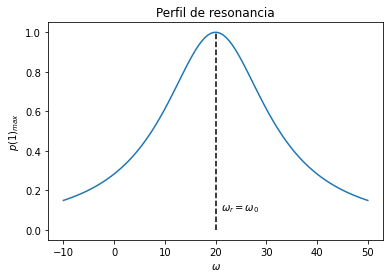

In [175]:
omegas = np.linspace(-B0,5*B0,100)
p1_max = B1**2 / (B1**2 + (omegas - 2*B0)**2/4)
## Dibujamos p1_max vs omega
plt.title('Perfil de resonancia')
plt.xlabel(r'$\omega$')
plt.ylabel(r'$p(1)_{max}$')
plt.vlines(2*B0,0.0,1.0,linestyle='dashed')
plt.text((2.1)*B0,0.1,r'$\omega_r = \omega_0$')
plt.plot(omegas,p1_max)
plt.show()

### Marco rotatorio y simulación con Qiskit

Siguiento a Barton, consideraremos un marco de referencia que rota con el campo magnético. Cualquier estado de espín en este marco se encuentra en realidad rotando en el marco estático original. La velocidad angular de rotación es $-\omega$, puesto que el campo rota en la dirección de las manecillas del reloj. Denotamos el estado de espín en el marco rotante por el ket $|\psi_R\rangle$. Postulamos la relación matemática

$$R_{\hat{z}}(-\omega t)|\psi_R\rangle = \mathrm{e}^{\mathrm{i}\frac{\omega t}{2} \hat{\sigma}_z}|\psi_R\rangle = |\psi\rangle$$

En primer lugar, enunciaremos la ecuación de movimiento para el estado de espín en el marco rotante. Posteriormente, procederemos a resolverla de forma exacta, y simular el sistema utilizando Qiskit.

**SUPER IMPORTANTE:** Aunque parezca un poco confuso, el factor $2$ en la rotación no lo utilizamos esta vez puesto que estamos utilizando la convención de computación cuántica sobre rotaciones.

#### Ecuación de movimiento en el marco rotante

La ecuación de movimiento en el marco estático es

$$\mathrm{i}\frac{\mathrm{d}}{\mathrm{d}t}|\psi\rangle = \hat{H} |\psi_R\rangle$$

Recordando el Hamiltoniano

$$\hat{H} = - B_0 \hat{\sigma}_z - B_1 \cos{\omega t} \hat{\sigma}_x + B_1 \sin{\omega t} \hat{\sigma}_y$$

No entraremos en los detalles matemáticos. Sin embargo, apuntamos a que al sustituir la espresión que relaciona los estados de espín en el marco rotante y el marco estático, hallamos la ecuación

$$\mathrm{i}\frac{\mathrm{d}}{\mathrm{d}t}|\psi_R\rangle = \bigg(\frac{\omega}{2} \hat{\sigma}_z + \hat{H}_{1R}\bigg) |\psi_R\rangle$$

Donde realizamos la definición

$$\hat{H}_{1R} = R_{\hat{z}}(\omega t)\hat{H}R_{\hat{z}}(-\omega t)$$

#### Solución exacta de la ecuación de movimiento

A primera vista, parece que la ecuación se ha complicado. Sin embargo, sucede lo contrario. Basta notar que los operadores de rotación transforman el Hamiltoniano del marco estático, al marco rotante.

> En el marco rotante, puesto que el campo magnético es estático, $\hat{H}_{1R}$ no depende del tiempo. Esto nos permite resolver la ecuación de movimiento sin dificultad.

De hecho, la dinámica del sistema está dada por

$$\mathrm{i}\frac{\mathrm{d}}{\mathrm{d}t} |\psi_R\rangle = - (\vec{B}' \cdot \hat{\sigma}) |\psi_R\rangle$$

Con $\vec{B}' = (B_0 - \omega) \hat{\mathbf{z}} + B_1 \hat{\mathbf{x}}$. Por simplicidad, definiremos

$$B = \sqrt{B_1^2 + (B_0 - \omega/2)^2}$$
$$\cos{\phi_0} = \frac{B_0 - \omega/2}{\sqrt{B_1^2 + (B_0 - \omega/2)^2}}$$
$$\sin{\phi_0} = \frac{B_1}{\sqrt{B_1^2 + (B_0 - \omega/2)^2}}$$

Tal que $\vec{B}' = B(\cos{\phi_0} \hat{\mathbf{z}} + \sin{\phi_0} \hat{\mathbf{x}}) = B\hat{n}$. Cn estas definiciones, no es dificil ver que la evolución temporal del **estado de espín en el marco estático** corresponde a una secuencia de rotaciones

$$|\psi(t)\rangle = R_{\hat{z}}(-\omega t) R_{\hat{n}}(-2Bt) |\psi(0)\rangle$$

> El vector de Bloch que representa el estado de espín realiza una doble rotación, primero en torno del eje $\hat{n}$, luego en torno del eje $\hat{z}$

En el caso particular en que $\omega = \omega_0 = 2B_0$, observamos que la rotación del vector de Bloch se realiza primero con respecto al eje $x$, luego con respecto al eje $z$. Si permitimos que el campo magnético actúe solo durante medio ciclo, conseguiremos que este se localice sobre el plano $xy$. Esta perturbación se denomina **pulso $\pi/2$**.

#### Simulación con Qiskit

Hemos visto que la simulación temporal solo requiere la aplicación de dos rotaciones. Qiskit ejecuta los algoritmos en dispositivos superconductores. Cualquier unitario (a menos de una fase global) se implementa por medio de rotaciones con respecto al eje $z$ y pulsos $\pi/2$, que corresponden a $R_{\hat{x}}(\pi/2)$. Además de una rotación sobre el eje $z$, debemos aplicar una rotación con respecto a un eje arbitrario. Por tanto, reescribimos esta última de la forma

$$R_{\hat{n}}(\theta) = \begin{bmatrix} \cos{\gamma/2} & -\mathrm{e}^{\mathrm{i}(-\delta - \pi/2)}\sin{\gamma/2} \\ \mathrm{e}^{\mathrm{i}(-\delta + \pi/2)}\sin{\gamma/2} & \mathrm{e}^{-\mathrm{i}2\delta}\cos{\gamma/2} \end{bmatrix}$$

Donde realizamos las definiciones

$$\tan{\delta} = \tan{\frac{\theta}{2}}\cos{\phi_0}$$
$$\tan{\frac{\gamma}{2}} = \frac{\sin{\frac{\theta}{2}}\cos{\phi_0}}{\sqrt{\cos^2{\frac{\theta}{2}}+\sin^2{\frac{\theta}{2}}\cos^2{\phi_0}}}$$

Por tanto, salvo una fase global, descompondremos nuestro operador de rotación de la siguiente manera

$$R_{\hat{n}}(\theta) = \hat{p}(-\delta + 3\pi/2) \cdot R_{\hat{x}}(\pi/2) \cdot \hat{p}(\gamma + \pi) \cdot R_{\hat{x}}(\pi/2) \cdot \hat{p}(-\delta - \pi/2) $$

> A la hora de implementar el circuito en el Hardware, esta descomposición solo implica la realización de 2 pulsos de microondas sobre el qubit. Las compuertas de fase, $\hat{p}$, se implmentan con total precisión, puesto que se aplican por software.

**NOTA:** Por completez, presentamos la definición de una compuerta de fase $\hat{p}(\lambda)$

$$\hat{p} = \begin{bmatrix}1 & 0 \\ 0 & \mathrm{e}^{\mathrm{i}\lambda}\end{bmatrix}$$

Procedemos a inicializar el circuito

In [176]:
## Declaramos el registro cuántico
particula = QuantumRegister(1,name='p')
## Declaramos el registro de medida
medida = ClassicalRegister(1,name='r')
## Creamos el circuito
SimulRot = QuantumCircuit(particula,medida)
## No necesitamos cargar el estado inicial

Posteriormente, definimos los parámetros asociados a la compuerta de rotación que hemos definido anteriormente

In [177]:
## Declaración de parámetros
gamma = Parameter('γ')         ## angulo de rotación
delta = Parameter('δ')         ## Fase operador
omega = Parameter('ω')         ## Frecuencia forzamiento
t = Parameter('t')             ## Tiempo a simular

Finalmente, aplicamos la secuencia de operadores que realizan la evolución temporal, recordando la descomposición de $R_{\hat{n}}(\theta)$. Convertiremos el circuito en una **secuencia de instrucciones**, que utilizaremos después.

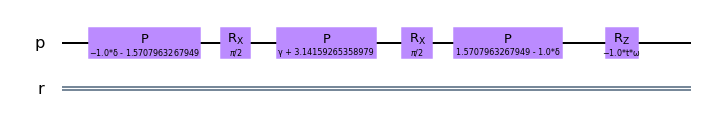

In [178]:
## Aplicamos R_n(theta). Ojo al orden
## p(φ+π) sx p(ϴ+π) sx p(λ)
SimulRot.p(-delta-np.pi/2,particula)
SimulRot.rx(np.pi/2,particula)
SimulRot.p(gamma+np.pi,particula)
SimulRot.rx(np.pi/2,particula)
SimulRot.p(-delta+np.pi/2,particula)
## Alternativamente, puede cargarse 
## el unitario con la siguiente instrución
## SimulRot.u(gamma,-delta+np.pi/2,-delta-np.pi/2,particula)
## Aplicamos Rz
SimulRot.rz(-omega*t,particula)
## Dibujamos circuito
SimulRot.draw(output='mpl')

Al proceder de esta forma, podremos repetir nuestro algoritmo de simulación varias veces sin preocuparnos por tener que insertar todas las instrucciones que lo componen. Procederemos a crear una función que nos permite calcular los valores de $B$, $\gamma$ y $\delta$ para valores dados de $B_0$, $B_1$, $t$ y $\omega$.

In [183]:
def Bmag(*params):
    '''
    Calculamos B magnitud.
    Los parametros son B0, B1,
    omega y t en ese orden
    '''
    return np.sqrt(params[1]**2 + ((params[0]-params[2]/2)**2)/4)
    
    
def cosphi0(*params):
    '''
    Calculamos cos(phi0).
    Los parametros son B0, B1,
    omega y t en ese orden
    '''
    return (params[0] - params[2]/2)/Bmag(*params)

def sinphi0(*params):
    '''
    Calculamos cos(phi0).
    Los parametros son B0, B1,
    omega y t en ese orden
    '''
    return params[1]/Bmag(*params)

def Delta(*params):
    '''
    Calculamos delta.
    Los parametros son B0, B1,
    omega y t en ese orden
    '''
    B = Bmag(*params)
    th = -2*B*params[3]
    return np.arctan(np.tan(th/2)*cosphi0(*params))

def Gamma(*params):
    '''
    Calculamos gamma.
    Los parametros son B0, B1,
    omega y t en ese orden
    '''
    B = Bmag(*params)
    s0 = sinphi0(*params)
    st = np.sin(-2*B*params[3]/2)
    return 2*np.arcsin(st*s0)

Ahora crearemos una rutina que nos permite calcular la densidad de probabilidad de medición en la base computacional para un tiempo dado. Simularemos el circuito utilizando el ```qasm_simulator```.

In [184]:
def PDF(*params):
    '''
    Los parámetros son B0, B1,
    omega y t en ese orden
    '''
    ## Creamos un circuito para simular
    circ = QuantumCircuit(particula,medida)
    ## Insertamos el algoritmo de evolución
    circ = circ + SimulRot
    ## Medimos el resultado
    circ.measure(particula,medida)
    ## Creamos diccionario para linkear
    ## parametros del circuito
    circ_params = {
        gamma:Gamma(*params),
        delta:Delta(*params),
        omega:params[2],
        t:params[3]
    }
    ## Linkeamos el circuito
    circ = circ.bind_parameters(circ_params)
    ## Simulamos el circuito
    cuentas = execute(circ,Aer.get_backend('qasm_simulator'),shots=2048).result().get_counts()
    return [cuentas.get('0',0)/2048, cuentas.get('1',0)/2048]

Procedemos entonces a simular la evolución temporal de la densidad de probabilidad. Utilizaremos los valores

$$B_0 = 10$$
$$B_1 = 2\pi$$
$$\omega = 2B_0$$

In [189]:
## Creamos los parametros
B0 = 10
B1 = 2*np.pi
frec = 2.0*B0
## Simulamos dos periodos
tiempos = np.linspace(0,2*np.pi/B1,200)
## Procedemos a generar la data
PDFvst = [PDF(B0,B1,frec,tiempo) for tiempo in tiempos]

Procedemos a graficar la densidad de probabilidad simulada

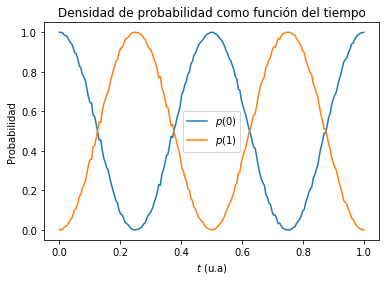

In [190]:
## Recopilamos lista de valores
p0 = [prob[0] for prob in PDFvst]
p1 = [prob[1] for prob in PDFvst]
## Graficamos
plt.title('Densidad de probabilidad como función del tiempo')
plt.xlabel(r'$t$ (u.a)')
plt.ylabel(r'Probabilidad')
plt.plot(tiempos,p0,label=r'$p(0)$')
plt.plot(tiempos,p1,label=r'$p(1)$')
plt.legend()
plt.show()

Podemos observar que cuando la frecuencia del campo magnético corresponde con la frecuancia de Larmor, el sistema se encuentra en resonancia. Invitamos al lector a probar distintos valores de la frecuencia del campo externo para comprobar que se reproducen los resultados obtenidos analíticamente.

## Perspectivas

Una de las aplicaciones más importantes del fenómeno que acabamos de estudiar es la **Resonancia magnética nuclear**. Los átomos de hidrógeno que componen muchos tejidos, en especial biológicos, se comportan como partículas de espín 1/2. En resumidas cuentas, el principio es caracterizar la curva de resonancia de un material (similar a las que hemos visto), que depende de su composición química. Como apunta Barton, dos tiempos característicos son importantes para determinar la composición de un tejido: el tiempo de decaimiento de las oscilaciones y el tiempo que toman los átomos en recuperar una polarización longitudinal.

La intuición que se ha desarrollado sobre este sistema magnético no está limitada a partículas con espín 1/2. Otra aplicación de gran impacto es el **MASER**, Microwave Amplification by Stimulated Emission of Radiation, por sus siglas en inglés. Por razones que no vamos a abordar aquí, la molécula de amonia puede considerarse como un sistema de dos niveles. Al interactuar con un campo eléctrico oscilante, es posible generar ciclos de excitación-decaimiento. En estos ciclos, el decaimiento conlleva la emisión de fotones con una energía equivalente a la diferencia entre la energía el estado excitado y la del estado base. Al preparar una gran cantidad de moléculas de amonia en el estado base (por medio de un experimento tipo Stern-Gerlach), podemos utilizar un campo eléctrico oscilante para producir un decaimiento coordinado de todas ellas. Esto deviene en la producción de una gran cantidad de de fotones coherentes. Si al lector el nombre MASER le recuerda a otro aparato ampliamente referenciado en la ciencia ficción, no tiene su intuición mal localizada.

1. Invitamos al lector con experiencia en mecánica cuántica a rellenar los detalles matemáticos. En el respositorio del grupo encontrará un documento con algunas pistas.

1. ¿Puede el lector imaginar un sistema de dos niveles con potenciales aplicaciones?

1. También los qubits superconductores pueden idealizarse como sistemas de dos niveles. Invitamos al lector a investigar sobre la forma como se implmentan las compuertas cuánticas en esta arquitectura, y qué tienen que ver los pulsos $\pi/2$ en el asunto.

1. Para el lector con formación en física ¿cómo simularía un sistema de dos espines en presencia de un campo magnético oscilante?

## Referencias

* Barton Zweibach. Two State Systems. OCW: Quantum Physics II. MIT. Recuperado el 05 de Marzo de 2021 de https://ocw.mit.edu/courses/physics/8-05-quantum-physics-ii-fall-2013/lecture-notes/MIT8_05F13_Chap_07.pdf
* Sakurai y Napolitano. Modern Quantum Mechanics. Cap. 5: Approximation Methods. Cambridge University Press.
* Nielsen & Chuang. Quantum Computation and Quantum Information. Cambridge University Press, 2010.

Muchas gracias por leer esta publicación! Abajo se encuentran links a las lecciones siguientes en el Crash Course de QC-FEM.